## Bibliotheken

In [1]:
import librosa
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tqdm import tqdm
import optuna

## Funktionen
### Read in, Extract Features, and Label Data

Zusammenfassung der Merkmale
MFCC - Mel-Frequenz-Cepstral-Koeffizienten: Die Stimme ist abhängig von der Form des Vokaltraktes einschließlich Zunge, Zähnen usw. Darstellung des Kurzzeit-Leistungsspektrums des Schalls, im Wesentlichen eine Darstellung des Vokaltraktes

STFT - liefert eine komplexwertige Matrix D von Kurzzeit-Fourier-Transformationskoeffizienten: Die Verwendung von abs(D[f,t]) gibt die Größe des Frequenzbereichs bin f bei Rahmen t zurück (Wird als Eingabe für Chroma_STFT verwendet)

Chroma_STFT - (12 Tonhöhenklassen) - (12 Tonhöhenklassen) unter Verwendung eines Energie-(Größen-)Spektrums (erhalten durch Verwendung des Absolutwerts der von libROSAs STFT-Funktion zurückgegebenen Matrix) anstelle des Leistungsspektrums liefert normierte Energie für jedes Chroma Bin bei jedem Frame

Mel-Spektrogramm - Magnitudenspektrogramm, das berechnet und dann auf der Mel-Skala abgebildet wird - die x-Achse ist die Zeit, die y-Achse die Frequenz


In [2]:
def extract_feature(file_name):
    """Function Extracts Features from WAV file"""
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

### Dictionary of Emotions and Function to Append Gender

In [3]:

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

def gender(g):
    """Returns Gender Label"""
    if int(g[0:2]) % 2 == 0:
        return 'female'
    else:
        return 'male'

In [4]:
def load_data(test_size=0.2):
    """Loads Data from directory containing WAV files."""
    x,y=[],[]
    for file in tqdm(glob.glob("C:\\Users\\Burlay\\Desktop\\FOM (Studium)\\3 Semestr\\Big-Data-Analyseprojekt (K)\\archive\\Actor_*\\*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] + '_' + gender(file_name.split("-")[-1])                 
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
        
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [63]:
#DataFlair - Split the dataset

X_train, X_test, y_train, y_test = load_data()

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [04:09<00:00,  5.78it/s]


In [8]:
print((X_train.shape[0], X_test.shape[0]))

(1152, 288)


In [9]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


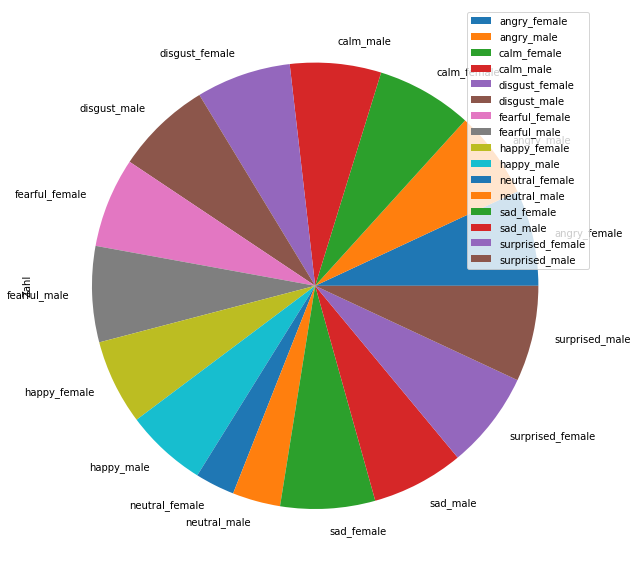

In [10]:
%matplotlib inline
y_pd = pd.DataFrame(y_train)
res_pd = pd.DataFrame({'Zahl':[1]},
                        index =y_train)
df = res_pd.groupby(level=0).sum()
plot = df.plot.pie(y='Zahl', figsize=(10,14 ))

## Scale Data

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Encoding

In [12]:
y_cla = np.array(y_train)
or_enc = preprocessing.OrdinalEncoder(categories = 'auto')
y_train_enc = or_enc.fit_transform(y_cla.reshape(-1, 1))

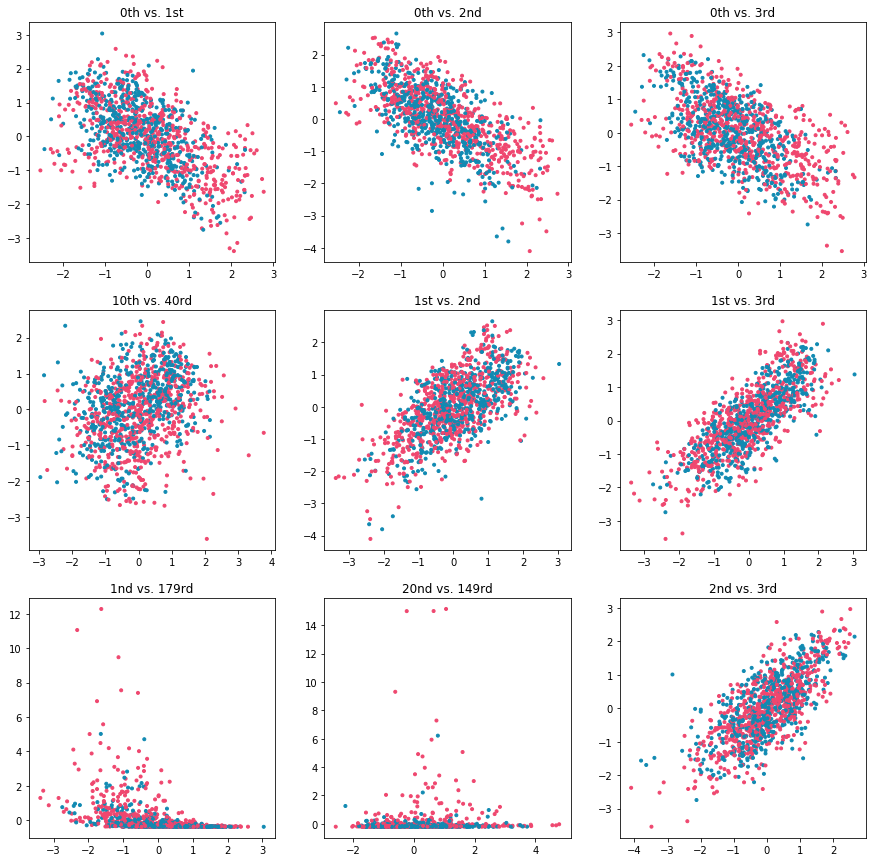

In [13]:
# Classification data set
owncmap = mc.ListedColormap(['#EF476F', '#118AB2'])
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))
ax[0, 0].scatter(X_train[:, 0], X_train[:, 1], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[0, 0].set_title('0th vs. 1st')
ax[0, 1].scatter(X_train[:, 0], X_train[:, 2], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[0, 1].set_title('0th vs. 2nd')
ax[0, 2].scatter(X_train[:, 0], X_train[:, 3], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[0, 2].set_title('0th vs. 3rd')
ax[1, 0].scatter(X_train[:, 10], X_train[:, 40], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[1, 0].set_title('10th vs. 40rd')
ax[1, 1].scatter(X_train[:, 1], X_train[:, 2], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[1, 1].set_title('1st vs. 2nd')
ax[1, 2].scatter(X_train[:, 1], X_train[:, 3], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[1, 2].set_title('1st vs. 3rd')
ax[2, 0].scatter(X_train[:, 1], X_train[:, 179], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[2, 0].set_title('1nd vs. 179rd')
ax[2, 1].scatter(X_train[:, 20], X_train[:, 149], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[2, 1].set_title('20nd vs. 149rd')
ax[2, 2].scatter(X_train[:, 2], X_train[:, 3], c = y_train_enc[:, 0], marker = '.', cmap = owncmap)
ax[2, 2].set_title('2nd vs. 3rd')
plt.draw()

## Parameter Dictionaries

In [14]:
rf_params = {'criterion': 'entropy', 
             'max_depth': 15, 
             'n_estimators': 22984, 
             'min_samples_leaf': 3, 
             'min_samples_split': 9, 
             'max_leaf_nodes': 239, 
             'random_state': 22}

dt_params = {'criterion': 'entropy', 
             'max_depth': 35, 
             'min_samples_leaf': 4, 
             'min_samples_split': 23, 
             'max_leaf_nodes': 169}

mlp_params = {'activation': 'relu', 
              'solver': 'lbfgs', 
              'hidden_layer_sizes': 1283, 
              'alpha': 0.3849485717707319, 
              'batch_size': 163, 
              'learning_rate': 'constant',
              'max_iter':1000}

knn_params = {'weights': 'distance', 
              'n_neighbors': 32}

lr_params = {'multi_class':'multinomial',
             'class_weight': None, 
             'solver': 'saga', 
             'max_iter':10000}

## Models and Labels Dictionaries

In [15]:
models = {'dt':DecisionTreeClassifier(**dt_params),
          'rf':RandomForestClassifier(**rf_params), 
          'mlp':MLPClassifier(**mlp_params), 
          'kn':KNeighborsClassifier(**knn_params),  
          'lr':LogisticRegression(**lr_params)}

model_abrv = {'dt':'Decision Tree Classifier', 
              'rf':'Random Forest Classifier', 
              'mlp':'MLP Classifier',
              'kn':'K-Nearest Neighbors', 
              'lr':'Logistic Regression'}

## Modeling and Statistics Functions

In [16]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a seaborn heatmap. 
    Saves confusion matrix file to jpg file."""
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('tuned_' + model_abrv[model] + '_confusion_matrix.jpg')
    plt.show()

In [17]:
def model(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, models=models, save=False, print_stat=True, inc_train=False, cv=False):
    """Trains models and outputs score metrics. Takes an identifier, list of models, and split dataset as inputs and has options for saving model, 
    printing confusion matrix and classification report and getting cross-validated 5 fold accuracy."""
    clf_model = models[clf]
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    if print_stat == True:
        clf_report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).T
        clf_report.to_csv('tuned_' + model_abrv[clf] + '_classification_report.csv')
        print(model_abrv[clf])
        print('\nTest Stats\n', classification_report(y_test,y_pred))
        print_confusion_matrix(confusion_matrix(y_test, y_pred), unique_labels(y_test, y_pred), model=clf)
        if inc_train == True:
            print(model_abrv[clf])
            print('\nTrain Stats\n', classification_report(y_train,clf_model.predict(X_train)))
            print_confusion_matrix(confusion_matrix(y_train, clf_model.predict(X_train)), unique_labels(y_test, y_pred), model=clf)
    if cv == True:
        print(model_abrv[clf] + ' CV Accuracy:',  
              np.mean(cross_val_score(clf_model, X_train, y_train, cv=5, scoring='accuracy')))
    if save == True:
        return clf_model

## Modelling

In [18]:
for key in models.keys():
    model(key, cv=True, print_stat=False)

Decision Tree Classifier CV Accuracy: 0.3307321663843402
Random Forest Classifier CV Accuracy: 0.5355693581780538
MLP Classifier CV Accuracy: 0.6675211744776963
K-Nearest Neighbors CV Accuracy: 0.3914812723508376
Logistic Regression CV Accuracy: 0.5668021833239225


Decision Tree Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.36      0.25      0.30        16
      angry_male       0.67      0.70      0.68        23
     calm_female       0.60      0.75      0.67        16
       calm_male       0.58      0.55      0.56        20
  disgust_female       0.14      0.12      0.13        17
    disgust_male       0.22      0.25      0.24        16
  fearful_female       0.39      0.62      0.48        21
    fearful_male       0.16      0.25      0.20        16
    happy_female       0.47      0.36      0.41        25
      happy_male       0.35      0.21      0.27        28
  neutral_female       0.30      0.20      0.24        15
    neutral_male       0.25      0.25      0.25         8
      sad_female       0.36      0.24      0.29        17
        sad_male       0.21      0.21      0.21        19
surprised_female       0.29      0.47      0.36        15
  surprised_male       0.31      

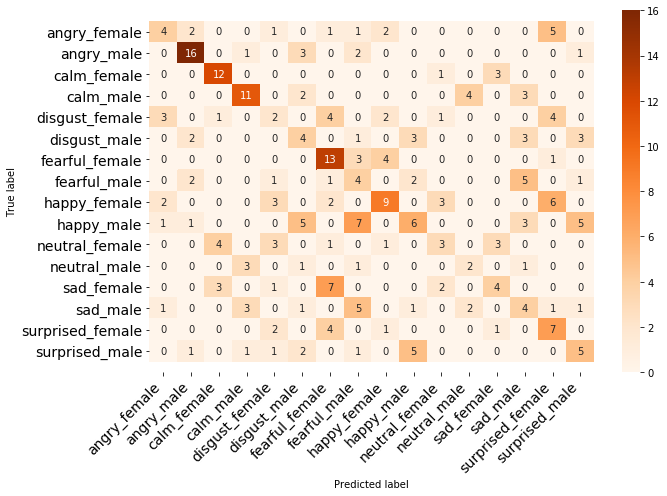

Decision Tree Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.78      0.76      0.77        80
      angry_male       0.81      0.85      0.83        73
     calm_female       0.90      0.75      0.82        80
       calm_male       0.76      0.88      0.82        76
  disgust_female       0.61      0.67      0.64        79
    disgust_male       0.72      0.61      0.66        80
  fearful_female       0.56      0.77      0.65        75
    fearful_male       0.53      0.79      0.63        80
    happy_female       0.56      0.55      0.55        71
      happy_male       0.48      0.38      0.43        68
  neutral_female       0.54      0.67      0.59        33
    neutral_male       0.67      0.30      0.41        40
      sad_female       0.84      0.59      0.70        79
        sad_male       0.61      0.71      0.66        77
surprised_female       0.81      0.63      0.71        81
  surprised_male       0.68     

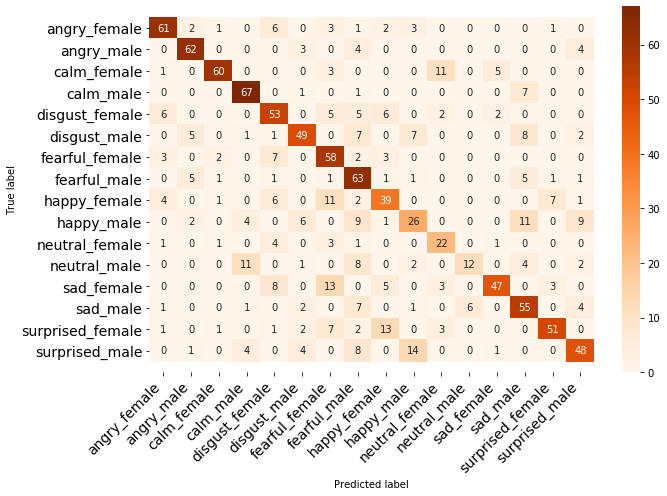

Random Forest Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.55      0.38      0.44        16
      angry_male       0.64      0.61      0.62        23
     calm_female       0.39      0.94      0.56        16
       calm_male       0.62      1.00      0.77        20
  disgust_female       0.40      0.47      0.43        17
    disgust_male       0.33      0.69      0.45        16
  fearful_female       0.78      0.67      0.72        21
    fearful_male       0.83      0.31      0.45        16
    happy_female       0.62      0.32      0.42        25
      happy_male       0.88      0.54      0.67        28
  neutral_female       0.50      0.20      0.29        15
    neutral_male       1.00      0.38      0.55         8
      sad_female       0.58      0.41      0.48        17
        sad_male       0.91      0.53      0.67        19
surprised_female       0.35      0.53      0.42        15
  surprised_male       0.43      

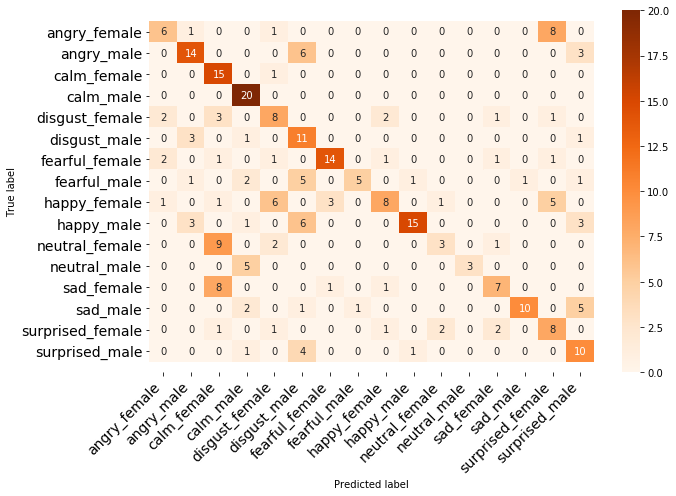

Random Forest Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      0.99      0.99        80
      angry_male       1.00      0.99      0.99        73
     calm_female       0.94      1.00      0.97        80
       calm_male       0.97      1.00      0.99        76
  disgust_female       1.00      0.97      0.99        79
    disgust_male       1.00      1.00      1.00        80
  fearful_female       1.00      0.99      0.99        75
    fearful_male       1.00      1.00      1.00        80
    happy_female       1.00      1.00      1.00        71
      happy_male       1.00      0.99      0.99        68
  neutral_female       1.00      0.97      0.98        33
    neutral_male       1.00      1.00      1.00        40
      sad_female       1.00      1.00      1.00        79
        sad_male       1.00      1.00      1.00        77
surprised_female       1.00      1.00      1.00        81
  surprised_male       1.00     

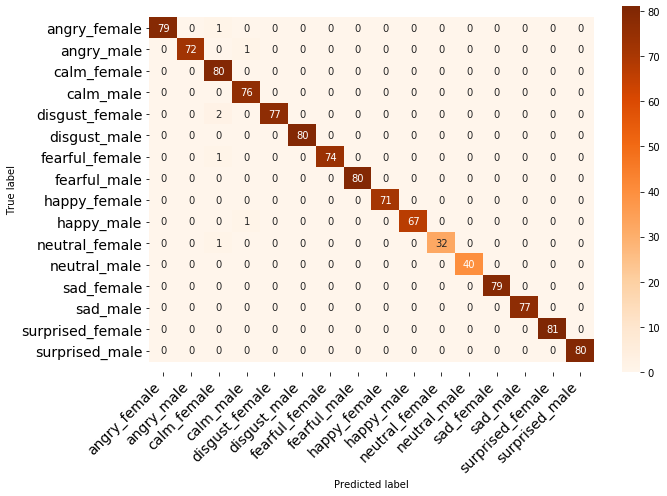

MLP Classifier

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.53      0.50      0.52        16
      angry_male       0.80      0.70      0.74        23
     calm_female       0.64      0.88      0.74        16
       calm_male       0.84      0.80      0.82        20
  disgust_female       0.64      0.53      0.58        17
    disgust_male       0.48      0.81      0.60        16
  fearful_female       0.75      0.71      0.73        21
    fearful_male       0.67      0.75      0.71        16
    happy_female       0.67      0.72      0.69        25
      happy_male       0.82      0.64      0.72        28
  neutral_female       0.82      0.60      0.69        15
    neutral_male       0.80      0.50      0.62         8
      sad_female       0.80      0.71      0.75        17
        sad_male       0.72      0.68      0.70        19
surprised_female       0.53      0.60      0.56        15
  surprised_male       0.67      0.75      

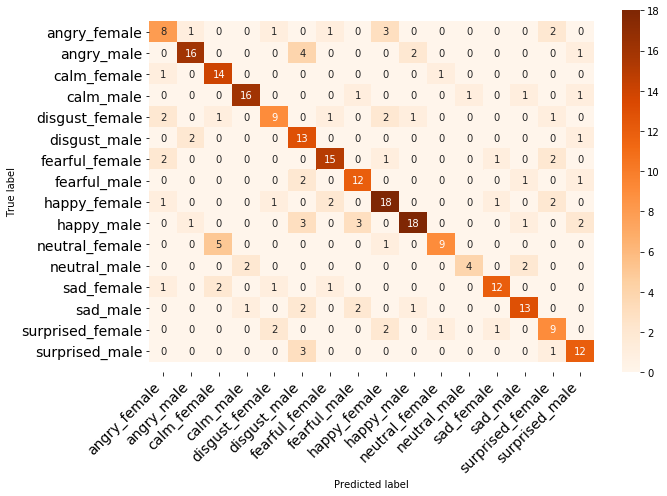

MLP Classifier

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00        80
      angry_male       1.00      1.00      1.00        73
     calm_female       1.00      1.00      1.00        80
       calm_male       1.00      1.00      1.00        76
  disgust_female       1.00      1.00      1.00        79
    disgust_male       1.00      1.00      1.00        80
  fearful_female       1.00      1.00      1.00        75
    fearful_male       1.00      1.00      1.00        80
    happy_female       1.00      1.00      1.00        71
      happy_male       1.00      1.00      1.00        68
  neutral_female       1.00      1.00      1.00        33
    neutral_male       1.00      1.00      1.00        40
      sad_female       1.00      1.00      1.00        79
        sad_male       1.00      1.00      1.00        77
surprised_female       1.00      1.00      1.00        81
  surprised_male       1.00      1.00     

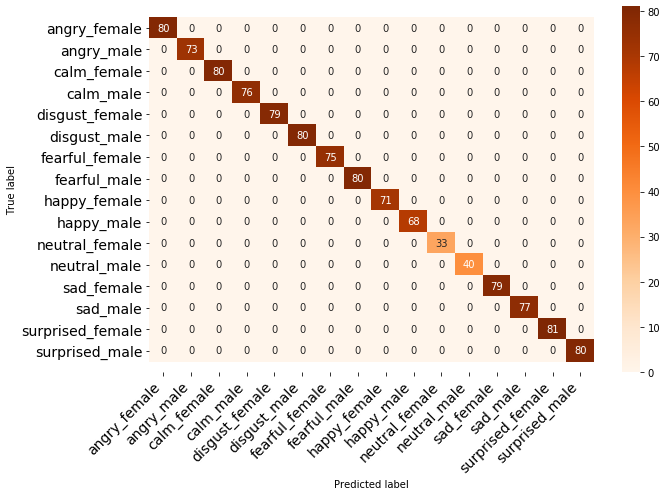

C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-Nearest Neighbors

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.60      0.19      0.29        16
      angry_male       0.47      0.35      0.40        23
     calm_female       0.41      1.00      0.58        16
       calm_male       0.62      0.90      0.73        20
  disgust_female       0.32      0.47      0.38        17
    disgust_male       0.27      0.44      0.33        16
  fearful_female       0.64      0.33      0.44        21
    fearful_male       0.18      0.12      0.15        16
    happy_female       0.71      0.20      0.31        25
      happy_male       0.88      0.25      0.39        28
  neutral_female       0.00      0.00      0.00        15
    neutral_male       0.25      0.25      0.25         8
      sad_female       1.00      0.12      0.21        17
        sad_male       0.38      0.32      0.34        19
surprised_female       0.22      0.87      0.35        15
  surprised_male       0.33      0.50 

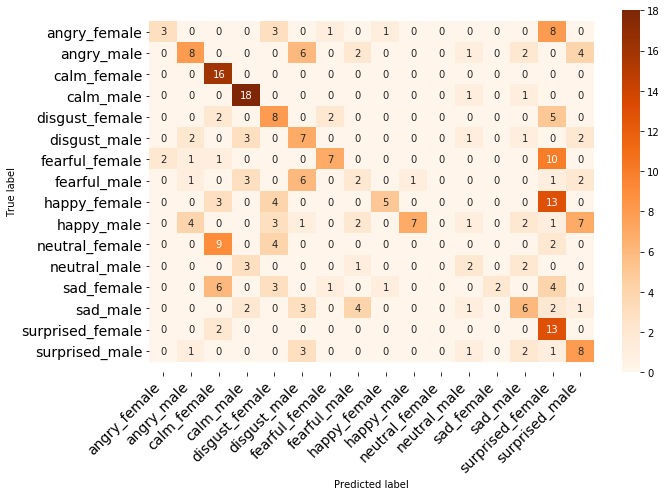

K-Nearest Neighbors

Train Stats
                   precision    recall  f1-score   support

    angry_female       1.00      1.00      1.00        80
      angry_male       1.00      1.00      1.00        73
     calm_female       1.00      1.00      1.00        80
       calm_male       1.00      1.00      1.00        76
  disgust_female       1.00      1.00      1.00        79
    disgust_male       1.00      1.00      1.00        80
  fearful_female       1.00      1.00      1.00        75
    fearful_male       1.00      1.00      1.00        80
    happy_female       1.00      1.00      1.00        71
      happy_male       1.00      1.00      1.00        68
  neutral_female       1.00      1.00      1.00        33
    neutral_male       1.00      1.00      1.00        40
      sad_female       1.00      1.00      1.00        79
        sad_male       1.00      1.00      1.00        77
surprised_female       1.00      1.00      1.00        81
  surprised_male       1.00      1.00

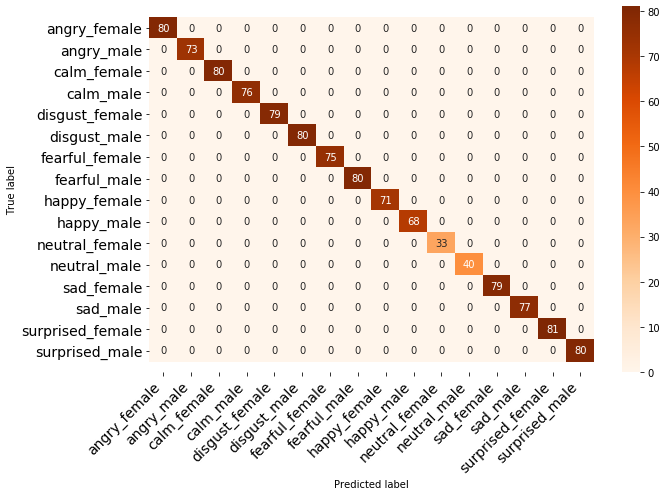

Logistic Regression

Test Stats
                   precision    recall  f1-score   support

    angry_female       0.50      0.50      0.50        16
      angry_male       0.63      0.52      0.57        23
     calm_female       0.58      0.88      0.70        16
       calm_male       0.75      0.75      0.75        20
  disgust_female       0.60      0.53      0.56        17
    disgust_male       0.37      0.62      0.47        16
  fearful_female       0.75      0.57      0.65        21
    fearful_male       0.44      0.50      0.47        16
    happy_female       0.72      0.72      0.72        25
      happy_male       0.64      0.50      0.56        28
  neutral_female       0.70      0.47      0.56        15
    neutral_male       0.50      0.38      0.43         8
      sad_female       0.59      0.59      0.59        17
        sad_male       0.37      0.37      0.37        19
surprised_female       0.47      0.53      0.50        15
  surprised_male       0.53      0.56 

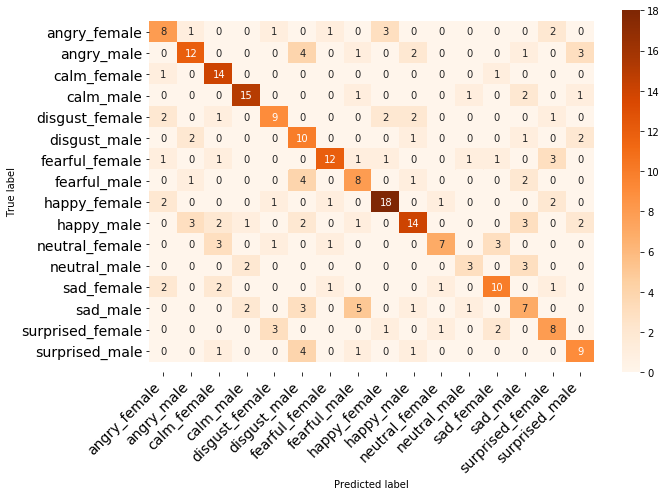

Logistic Regression

Train Stats
                   precision    recall  f1-score   support

    angry_female       0.97      0.89      0.93        80
      angry_male       0.97      0.99      0.98        73
     calm_female       0.77      0.85      0.81        80
       calm_male       0.78      0.86      0.82        76
  disgust_female       0.80      0.82      0.81        79
    disgust_male       0.87      0.72      0.79        80
  fearful_female       0.91      0.95      0.93        75
    fearful_male       0.87      0.84      0.85        80
    happy_female       0.93      0.93      0.93        71
      happy_male       0.84      0.76      0.80        68
  neutral_female       0.68      0.64      0.66        33
    neutral_male       0.69      0.60      0.64        40
      sad_female       0.78      0.75      0.76        79
        sad_male       0.58      0.69      0.63        77
surprised_female       0.84      0.86      0.85        81
  surprised_male       0.83      0.85

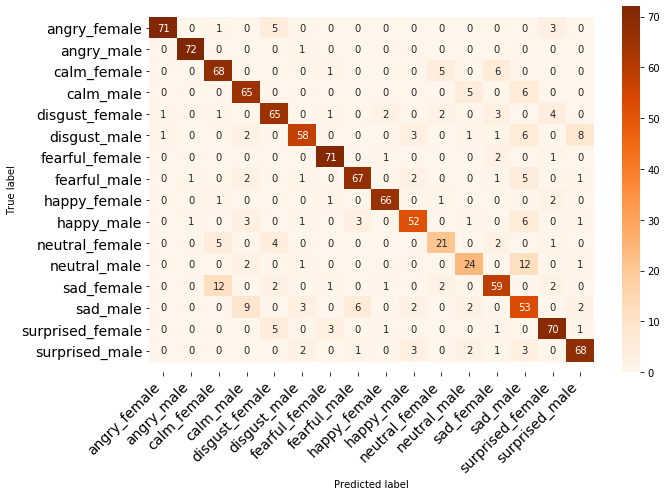

In [19]:
for key in models.keys():
    model(key, inc_train=True)

## Schreiben Daten zu csv Dateien

In [ ]:
for file, name in zip([X_train, X_test, y_train, y_test],['X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv']):
    pd.DataFrame(file).to_csv(name, index=False)

## Hyperparameter Tuning mit Optuna

Einem Modell Restriktion aufzuerlegen, um es zu vereinfachen und das Risiko für Overfitting zu reduzieren, wird as Regularisierung bezeichnet.
Die Stärke der Regularisierung beim Lernen lässt sich über einen Hyperparameter kontrollieren.
Ein Hyperparameter ist ein Parameter des Lernalgorithmus(nicht des Modell)

Bei den Modellparametern geht es um die Gewichte und Koeffizienten, die vom Algorithmus aus den Daten erfasst werden. Modellparameter betrachten, wie die Zielvariable in 
Abhängigkeit von der Prädiktor variablen ist. Hyperparameter hängen ausschließlich vom Verhalten des Algorithmus ab, wenn dieser sich in der Lernphase befindet. Jeder Algorithmus hat seinen eindeutigen Satz von Hyperparametern, wie bei Entscheidungsbäumen ein Tiefenparameter. 

Der Hyperparameter ist der Standardparameter, der in allen Situationen funktioniert. Sie werden als wichtiger Teil eines Modells bezeichnet. Es ist nicht notwendig, dass Sie nur die Standardparameter verwenden können, die Sie, wenn die Situation es erfordert, anpassen können. Es ist wichtig, drei Sätze zu haben, in denen die Daten unterteilt sind, wie z.B.  Trainings-, Test- und Validierungssätze, wenn Sie am Standardparameter Korrekturen vornehmen, um die erforderliche Genauigkeit zu erreichen und Datenlecks zu stoppen.

Modell-Hyperparameter sind die Aktivposten, die für das gesamte Training eines Algorithmus sorgen.
Während ein Algorithmus den Modellparameter aus den Daten lernt, werden die Hyperparameter verwendet, um das Verhalten des Algorithmus zu steuern. 
Diese Parameter werden initialisiert, bevor ein Training des Algorithmus stattfinde

## Random Forest

In [20]:
def objective_rf(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'n_estimators': trial.suggest_int('n_estimators', 15000, 25000),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
   
    model = RandomForestClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=5)

[I 2020-10-20 11:39:37,021] A new study created in memory with name: no-name-d848a7e5-1992-42fc-8b14-a4a29df7150e
[I 2020-10-20 11:48:33,788] Trial 0 finished with value: 0.5416412572934312 and parameters: {'criterion': 'gini', 'max_depth': 21, 'n_estimators': 15075, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_leaf_nodes': 229}. Best is trial 0 with value: 0.5416412572934312.
[I 2020-10-20 11:59:17,457] Trial 1 finished with value: 0.4774214191605496 and parameters: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 21103, 'min_samples_leaf': 5, 'min_samples_split': 23, 'max_leaf_nodes': 68}. Best is trial 0 with value: 0.5416412572934312.
[I 2020-10-20 12:47:17,944] Trial 2 finished with value: 0.5060718991153774 and parameters: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 20708, 'min_samples_leaf': 3, 'min_samples_split': 18, 'max_leaf_nodes': 244}. Best is trial 0 with value: 0.5416412572934312.
[I 2020-10-20 13:23:11,112] Trial 3 finished with value: 0.50780

## MLP

In [21]:
def objective_mlp(trial):

    params = {
        'activation': trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'hidden_layer_sizes':trial.suggest_int('hidden_layer_sizes', 100, 1500),
        'alpha': trial.suggest_uniform('alpha', 0.001, 0.99),
        'batch_size':trial.suggest_int('batch_size', 150, 300), 
        'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant', 'invscaling']),
        'max_iter': 2000
        }
  
    model = MLPClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=15)

[I 2020-10-20 17:41:52,947] A new study created in memory with name: no-name-523bc4a6-9b4c-4165-9a27-01f176734cd4
C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: 

C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2020-10-20 18:24:00,318] Trial 11 finished with value: 0.6597214379823075 and parameters: {'activation': 'relu', 'solver': 'lbfgs', 'hidden_layer_sizes': 553, 'alpha': 0.9736996666184345, 'batch_size': 296, 'learning_rate': 'invscaling'}. Best is trial 10 with value: 0.665785808394504.
C:\Users\Burlay\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

## KNN

In [22]:
def objective_knn(trial):

    params = { 
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
        }

    model = KNeighborsClassifier(**params) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=10)

[I 2020-10-20 19:19:12,581] A new study created in memory with name: no-name-d16a6f72-12ec-4e4d-9311-d8602e384361
[I 2020-10-20 19:19:13,059] Trial 0 finished with value: 0.3263956333521551 and parameters: {'weights': 'distance', 'n_neighbors': 100}. Best is trial 0 with value: 0.3263956333521551.
[I 2020-10-20 19:19:13,545] Trial 1 finished with value: 0.2743421795595709 and parameters: {'weights': 'uniform', 'n_neighbors': 138}. Best is trial 0 with value: 0.3263956333521551.
[I 2020-10-20 19:19:14,042] Trial 2 finished with value: 0.2647844908714474 and parameters: {'weights': 'uniform', 'n_neighbors': 173}. Best is trial 0 with value: 0.3263956333521551.
[I 2020-10-20 19:19:14,526] Trial 3 finished with value: 0.342909843779409 and parameters: {'weights': 'distance', 'n_neighbors': 84}. Best is trial 3 with value: 0.342909843779409.
[I 2020-10-20 19:19:15,044] Trial 4 finished with value: 0.30385846038019954 and parameters: {'weights': 'distance', 'n_neighbors': 142}. Best is trial

## Decision Tree

In [23]:
def objective_dt(trial):
    
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 250),
        }
    
    model = DecisionTreeClassifier(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=5)

[I 2020-10-20 19:19:24,725] A new study created in memory with name: no-name-874966d6-49fd-4509-af10-28931373cda3
[I 2020-10-20 19:19:26,821] Trial 0 finished with value: 0.33593450028232635 and parameters: {'criterion': 'entropy', 'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_leaf_nodes': 65}. Best is trial 0 with value: 0.33593450028232635.
[I 2020-10-20 19:19:28,845] Trial 1 finished with value: 0.3324788255223038 and parameters: {'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 4, 'min_samples_split': 18, 'max_leaf_nodes': 146}. Best is trial 0 with value: 0.33593450028232635.
[I 2020-10-20 19:19:29,525] Trial 2 finished with value: 0.36720120459250893 and parameters: {'criterion': 'gini', 'max_depth': 81, 'min_samples_leaf': 5, 'min_samples_split': 9, 'max_leaf_nodes': 223}. Best is trial 2 with value: 0.36720120459250893.
[I 2020-10-20 19:19:30,211] Trial 3 finished with value: 0.3680820628646716 and parameters: {'criterion': 'gini', 'max_depth'

## Logistic Regression

In [27]:
def objective_lr(trial):
    params = { 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga', 'lbfgs']),
        'multi_class':'multinomial',
        'max_iter': 5000
        }
    
    model = LogisticRegression(**params, random_state = 22) 
    
    model.set_params(**params)

    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=10)

[I 2020-10-19 21:53:31,069] A new study created in memory with name: no-name-ea13eed3-9023-4235-ac84-e0186b3240a6
[I 2020-10-19 21:53:33,325] Trial 0 finished with value: 0.5668097120271034 and parameters: {'class_weight': None, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.5668097120271034.
[I 2020-10-19 21:53:35,587] Trial 1 finished with value: 0.5633389798607189 and parameters: {'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 0 with value: 0.5668097120271034.
[I 2020-10-19 21:54:55,008] Trial 2 finished with value: 0.5659363824581215 and parameters: {'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.5668097120271034.
[I 2020-10-19 21:54:57,229] Trial 3 finished with value: 0.5633389798607189 and parameters: {'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 0 with value: 0.5668097120271034.
[I 2020-10-19 21:57:37,861] Trial 4 finished with value: 0.5676717485413139 and parameters: {'class_weight': None, 'solver': 'saga'}

## Visualisierung MLP

In [64]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
mlp=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [65]:
#DataFlair - Train the model
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### The mean accuracy on the given test data and labels.

In [82]:
mlp.score(X_test, y_test)

0.5868055555555556

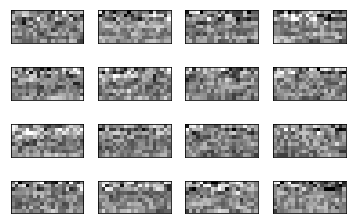

In [26]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(9,20), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

## Das Modell ist gelehrnt und bereit zu klassifizieren . Z.b Vier Dateien von Crema-D Dataset

In [80]:
def load_dat():
    """Loads Data from directory containing WAV files."""
    x,y=[],[]
    for file in tqdm(glob.glob("C:\\Users\\Burlay\\Desktop\\FOM (Studium)\\3 Semestr\\Big-Data-Analyseprojekt (K)\\CREMA-D\\*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] + '_' + gender(file_name.split("-")[-1])                 
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
        
    return np.array(x)

In [81]:
X = load_dat()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.64it/s]


In [84]:
X_CREMA = scaler.fit_transform(X)

In [85]:
pd.DataFrame(mlp.predict(X_CREMA)).rename(columns={0: "Emotionen"})

,Emotionen
0,angry_male
1,sad_female
2,sad_female
3,disgust_male
